# Grid Search Configuration Rankings

This notebook analyzes grid search experiments and ranks the best configurations for each federated learning aggregator.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import yaml
from typing import Dict, List

# Set plotting parameters for paper-ready figures
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

## 1. Parse Experiment Results with Configuration Parameters

In [2]:
def parse_experiment_dir(exp_dir: Path) -> Dict:
    """Parse a single experiment directory and extract metrics and parameters from config.yaml."""
    result = {}
    
    # Parse directory name for basic info
    dir_name = exp_dir.name
    
    # Extract aggregator from directory name
    agg_match = re.search(r'aggregator_aggregator_(\w+)', dir_name)
    if agg_match:
        result['aggregator'] = agg_match.group(1).split('_')[0]
    
    # Load parameters from config.yaml
    config_file = exp_dir / 'config.yaml'
    if config_file.exists():
        try:
            with open(config_file, 'r') as f:
                config = yaml.safe_load(f)
            
            # Extract aggregator parameters
            if 'experiment' in config and 'aggregator' in config['experiment']:
                agg_config = config['experiment']['aggregator']
                
                # Get aggregator name if not already found
                if 'aggregator' not in result and 'aggregator' in agg_config:
                    result['aggregator'] = agg_config['aggregator']
                
                # Extract parameters
                if 'params' in agg_config and agg_config['params']:
                    for param, value in agg_config['params'].items():
                        result[param] = value
            
            # Extract dataset partitioning parameters (alpha)
            if 'experiment' in config and 'dataset' in config['experiment']:
                if 'partitioning' in config['experiment']['dataset']:
                    part_config = config['experiment']['dataset']['partitioning']
                    if 'params' in part_config and part_config['params']:
                        if 'alpha' in part_config['params']:
                            result['alpha'] = part_config['params']['alpha']
        except Exception as e:
            print(f"Error reading config from {exp_dir}: {e}")
    
    # Load metrics
    metrics_file = exp_dir / 'global_metrics.csv'
    if metrics_file.exists():
        try:
            metrics_df = pd.read_csv(metrics_file)
            result['metrics'] = metrics_df
            
            # Calculate final accuracy
            test_metrics = metrics_df[metrics_df['metric'] == 'test_metric']
            if not test_metrics.empty:
                last_round = test_metrics['round'].max()
                final_metrics = test_metrics[test_metrics['round'] == last_round]
                result['final_accuracy'] = final_metrics['value'].mean()
                result['final_accuracy_std'] = final_metrics['value'].std()
                result['best_accuracy'] = test_metrics.groupby('round')['value'].mean().max()
        except Exception as e:
            print(f"Error reading metrics from {exp_dir}: {e}")
    
    result['exp_dir'] = exp_dir
    return result


def load_all_experiments(base_dirs: List[str]) -> pd.DataFrame:
    """Load all experiments from multiple result directories."""
    all_experiments = []
    
    for base_dir in base_dirs:
        base_path = Path(base_dir)
        if not base_path.exists():
            print(f"Warning: {base_path} does not exist")
            continue
        
        print(f"\nLoading experiments from {base_path}...")
        exp_count = 0
        
        # Find all experiment directories
        for exp_dir in base_path.iterdir():
            if exp_dir.is_dir() and not exp_dir.name.startswith('.'):
                exp_data = parse_experiment_dir(exp_dir)
                if 'final_accuracy' in exp_data and 'aggregator' in exp_data:
                    all_experiments.append(exp_data)
                    exp_count += 1
        
        print(f"  Found {exp_count} valid experiments")
    
    if not all_experiments:
        return pd.DataFrame()
    
    # Convert to DataFrame
    df = pd.DataFrame(all_experiments)
    return df

## 2. Load All Experiments

In [3]:
# Define result directories
result_dirs = [
    '../../../results_fedadagrad_grid',
    '../../../results_fedadam_grid',
    '../../../results_fedyogi_grid',
    #'../../../results_scaffold_grid',
    '../../../results_fedprox_grid',
    '../../../results_all',
]

# Load all experiments
print("="*80)
print("LOADING EXPERIMENTS")
print("="*80)

experiments_df = load_all_experiments(result_dirs)

if not experiments_df.empty:
    print(f"\nTotal experiments loaded: {len(experiments_df)}")
    print(f"Aggregators found: {sorted(experiments_df['aggregator'].unique())}")
else:
    print("\nNo experiments found. Please run the grid search commands first.")

LOADING EXPERIMENTS

Loading experiments from ../../../results_fedadagrad_grid...
  Found 18 valid experiments

Loading experiments from ../../../results_fedadam_grid...
  Found 12 valid experiments

Loading experiments from ../../../results_fedyogi_grid...
  Found 8 valid experiments

Loading experiments from ../../../results_fedprox_grid...
  Found 4 valid experiments

Loading experiments from ../../../results_all...
  Found 2 valid experiments

Total experiments loaded: 44
Aggregators found: ['FedAdagrad', 'FedAdam', 'FedAvg', 'FedMedian', 'FedProx', 'FedYogi']


## 3. Rank Configurations Per Aggregator

In [4]:
def format_param_value(value):
    """Format parameter values for display."""
    if isinstance(value, float):
        if value < 0.001:
            return f"{value:.2e}"
        else:
            return f"{value:.4f}" if value < 1 else f"{value:.2f}"
    return str(value)


def print_ranked_configs(df: pd.DataFrame, aggregator: str, top_n: int = 5):
    """Print ranked configurations for a specific aggregator."""
    agg_df = df[df['aggregator'] == aggregator].copy()
    
    if agg_df.empty:
        print(f"No experiments found for {aggregator}")
        return
    
    # Sort by final accuracy (descending)
    agg_df = agg_df.sort_values('final_accuracy', ascending=False)
    
    print(f"\n" + "="*80)
    print(f"RANKINGS FOR {aggregator.upper()}")
    print("="*80)
    print(f"Total configurations tested: {len(agg_df)}")
    print(f"Top {min(top_n, len(agg_df))} configurations:\n")
    
    # Get parameter columns (exclude non-parameter columns)
    exclude_cols = ['aggregator', 'final_accuracy', 'final_accuracy_std', 
                   'best_accuracy', 'metrics', 'exp_dir']
    param_cols = [col for col in agg_df.columns if col not in exclude_cols]
    
    for rank, (idx, row) in enumerate(agg_df.head(top_n).iterrows(), 1):
        print(f"Rank #{rank}:")
        print(f"  Accuracy: {row['final_accuracy']:.4f}", end="")
        if 'final_accuracy_std' in row and not pd.isna(row['final_accuracy_std']) and row['final_accuracy_std'] > 0:
            print(f" ± {row['final_accuracy_std']:.4f}")
        else:
            print()
        
        print("  Parameters:")
        for param in sorted(param_cols):
            if param in row and not pd.isna(row[param]):
                print(f"    {param}: {format_param_value(row[param])}")
        print()
    
    return agg_df


# Print rankings for each aggregator
if not experiments_df.empty:
    ranked_dfs = {}
    
    for aggregator in sorted(experiments_df['aggregator'].unique()):
        ranked_df = print_ranked_configs(experiments_df, aggregator, top_n=5)
        if ranked_df is not None:
            ranked_dfs[aggregator] = ranked_df
else:
    print("No experiments to rank.")


RANKINGS FOR FEDADAGRAD
Total configurations tested: 18
Top 5 configurations:

Rank #1:
  Accuracy: 0.6391 ± 0.1491
  Parameters:
    alpha: 0.1000
    beta_1: 0.9000
    eta: 0.0100
    tau: 1.00e-06

Rank #2:
  Accuracy: 0.6346 ± 0.1959
  Parameters:
    alpha: 0.1000
    beta_1: 0.9000
    eta: 0.1000
    tau: 0.0010

Rank #3:
  Accuracy: 0.5535 ± 0.2123
  Parameters:
    alpha: 0.1000
    beta_1: 0.9900
    eta: 0.1000
    tau: 1.00e-06

Rank #4:
  Accuracy: 0.4856 ± 0.2479
  Parameters:
    alpha: 0.1000
    beta_1: 0.9000
    eta: 0.1000
    tau: 1.00e-09

Rank #5:
  Accuracy: 0.4719 ± 0.1936
  Parameters:
    alpha: 0.1000
    beta_1: 0.9000
    eta: 0.1000
    tau: 1.00e-06


RANKINGS FOR FEDADAM
Total configurations tested: 12
Top 5 configurations:

Rank #1:
  Accuracy: 0.5397 ± 0.2343
  Parameters:
    alpha: 0.1000
    beta_1: 0.9900
    beta_2: 0.9900
    eta: 0.0100
    tau: 1.00e-06

Rank #2:
  Accuracy: 0.5270 ± 0.1649
  Parameters:
    alpha: 0.1000
    beta_1: 0.9900


## 4. Best Accuracy Per Aggregator

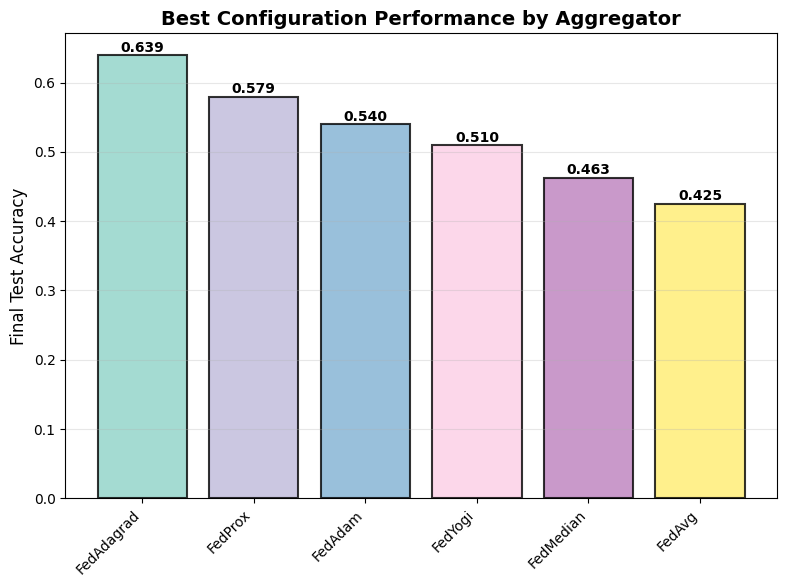

In [5]:
if not experiments_df.empty:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    best_accs = experiments_df.groupby('aggregator')['final_accuracy'].max().sort_values(ascending=False)
    colors = plt.cm.Set3(np.linspace(0, 1, len(best_accs)))
    bars = ax.bar(range(len(best_accs)), best_accs.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xticks(range(len(best_accs)))
    ax.set_xticklabels(best_accs.index, rotation=45, ha='right')
    ax.set_ylabel('Final Test Accuracy', fontsize=12)
    ax.set_title('Best Configuration Performance by Aggregator', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, best_accs.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

## 5. Accuracy Distribution Across Configurations

/var/folders/xr/1bjxmcqj21q_gr5001wl4l3m0000gn/T/ipykernel_59770/3844445132.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(acc_data, labels=agg_names, patch_artist=True)


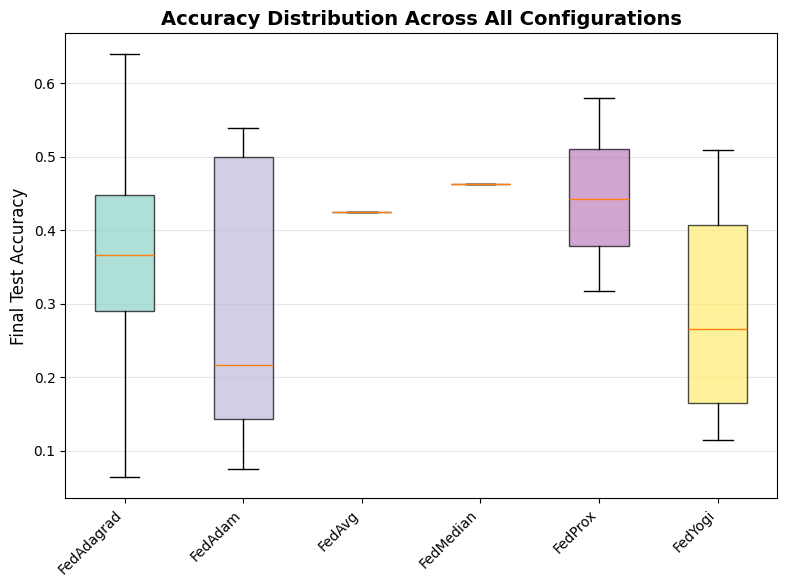

In [6]:
if not experiments_df.empty:
    fig, ax = plt.subplots(figsize=(8, 6))
    
    agg_names = sorted(experiments_df['aggregator'].unique())
    acc_data = [experiments_df[experiments_df['aggregator'] == agg]['final_accuracy'].values 
                for agg in agg_names]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(agg_names)))
    bp = ax.boxplot(acc_data, labels=agg_names, patch_artist=True)
    
    # Color the box plots
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticklabels(agg_names, rotation=45, ha='right')
    ax.set_ylabel('Final Test Accuracy', fontsize=12)
    ax.set_title('Accuracy Distribution Across All Configurations', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for box plot.")

## 6. Learning Curves for Best Configurations

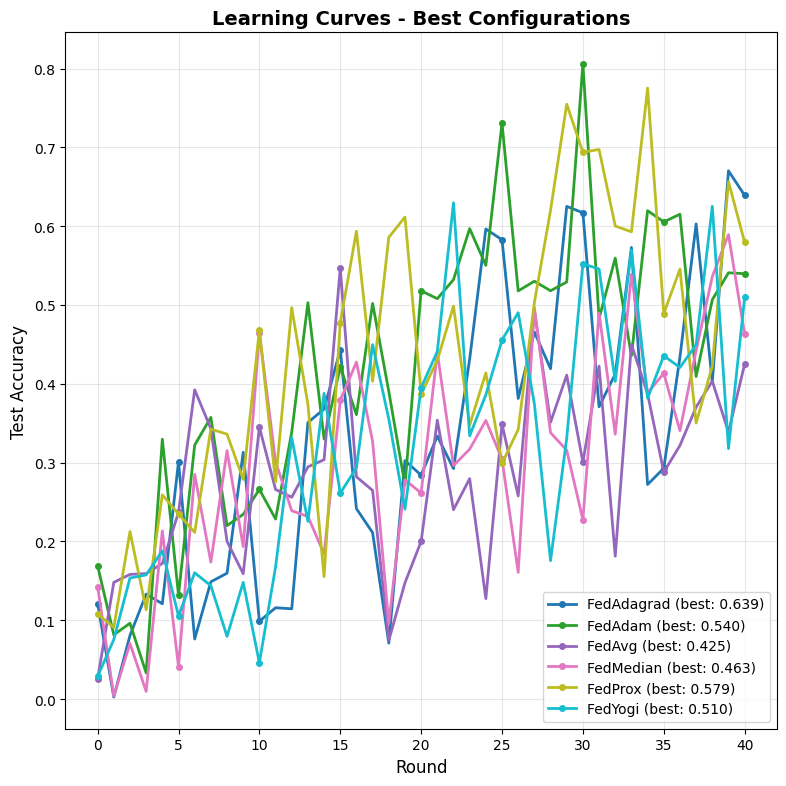

In [7]:
if not experiments_df.empty:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(experiments_df['aggregator'].unique())))
    
    for idx, agg in enumerate(sorted(experiments_df['aggregator'].unique())):
        agg_df = experiments_df[experiments_df['aggregator'] == agg]
        if not agg_df.empty:
            best_exp = agg_df.loc[agg_df['final_accuracy'].idxmax()]
            
            if 'metrics' in best_exp and best_exp['metrics'] is not None:
                metrics = best_exp['metrics']
                test_metrics = metrics[metrics['metric'] == 'test_metric']
                if not test_metrics.empty:
                    round_means = test_metrics.groupby('round')['value'].mean()
                    ax.plot(round_means.index, round_means.values,
                            label=f"{agg} (best: {best_exp['final_accuracy']:.3f})",
                            linewidth=2, marker='o', markersize=4, markevery=5, color=colors[idx])
    
    ax.set_xlabel('Round', fontsize=12)
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Learning Curves - Best Configurations', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for learning curves.")

## 7. Configuration Count Per Aggregator

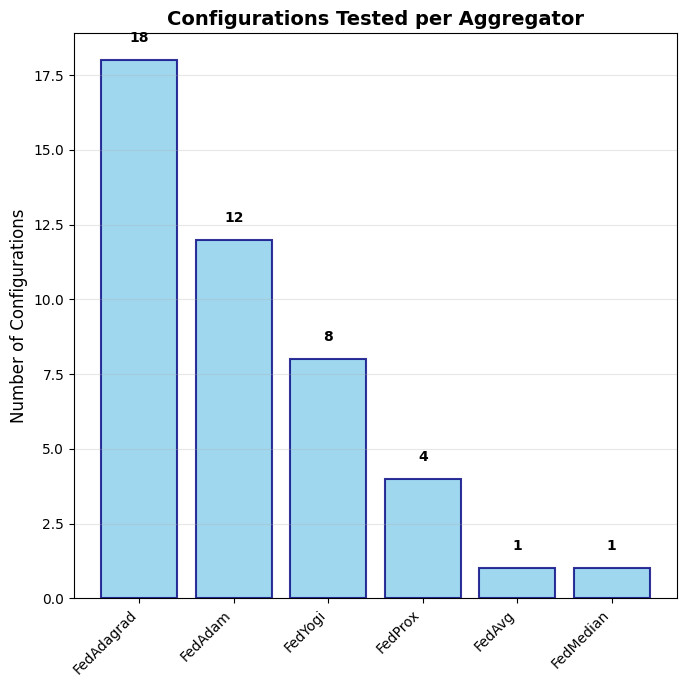

In [8]:
if not experiments_df.empty:
    fig, ax = plt.subplots(figsize=(7, 7))
    
    config_counts = experiments_df.groupby('aggregator').size().sort_values(ascending=False)
    bars = ax.bar(range(len(config_counts)), config_counts.values, color='skyblue', alpha=0.8, edgecolor='navy', linewidth=1.5)
    
    ax.set_xticks(range(len(config_counts)))
    ax.set_xticklabels(config_counts.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Configurations', fontsize=12)
    ax.set_title('Configurations Tested per Aggregator', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, config_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for configuration count.")

## 8. Ranked Configurations Plot

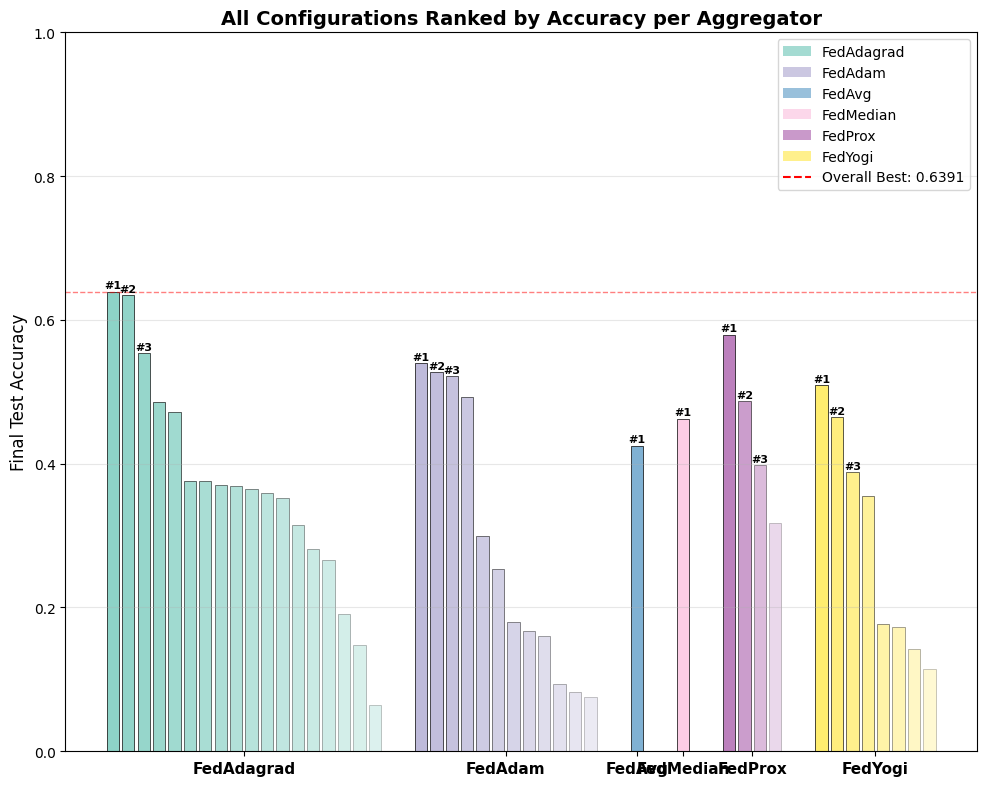


SUMMARY STATISTICS

FedAdagrad:
  Configurations tested: 18
  Best accuracy: 0.6391
  Worst accuracy: 0.0643
  Mean accuracy: 0.3677
  Std deviation: 0.1528

FedAdam:
  Configurations tested: 12
  Best accuracy: 0.5397
  Worst accuracy: 0.0758
  Mean accuracy: 0.2831
  Std deviation: 0.1871

FedAvg:
  Configurations tested: 1
  Best accuracy: 0.4251
  Worst accuracy: 0.4251
  Mean accuracy: 0.4251
  Std deviation: nan

FedMedian:
  Configurations tested: 1
  Best accuracy: 0.4628
  Worst accuracy: 0.4628
  Mean accuracy: 0.4628
  Std deviation: nan

FedProx:
  Configurations tested: 4
  Best accuracy: 0.5794
  Worst accuracy: 0.3180
  Mean accuracy: 0.4456
  Std deviation: 0.1128

FedYogi:
  Configurations tested: 8
  Best accuracy: 0.5095
  Worst accuracy: 0.1147
  Mean accuracy: 0.2907
  Std deviation: 0.1565


In [9]:
if not experiments_df.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Prepare data for plotting
    aggregators = sorted(experiments_df['aggregator'].unique())
    colors = plt.cm.Set3(np.linspace(0, 1, len(aggregators)))
    
    x_offset = 0
    x_positions = []
    x_labels = []
    
    for agg_idx, agg in enumerate(aggregators):
        agg_df = experiments_df[experiments_df['aggregator'] == agg].sort_values('final_accuracy', ascending=False)
        
        if not agg_df.empty:
            # Plot all configurations for this aggregator
            n_configs = len(agg_df)
            x_pos = np.arange(x_offset, x_offset + n_configs)
            
            # Create bars with gradient effect (best configs darker)
            alphas = np.linspace(1.0, 0.3, n_configs)
            for i, (idx, row) in enumerate(agg_df.iterrows()):
                bar = ax.bar(x_pos[i], row['final_accuracy'], 
                           color=colors[agg_idx], alpha=alphas[i],
                           edgecolor='black', linewidth=0.5)
                
                # Add rank labels for top 3
                if i < 3:
                    ax.text(x_pos[i], row['final_accuracy'] + 0.002,
                           f'#{i+1}', ha='center', va='bottom', fontsize=8, fontweight='bold')
            
            # Add aggregator label
            x_positions.append(x_offset + n_configs/2 - 0.5)
            x_labels.append(agg)
            
            # Update offset for next aggregator
            x_offset += n_configs + 2
    
    # Customize plot
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=0, ha='center', fontsize=11, fontweight='bold')
    ax.set_ylabel('Final Test Accuracy', fontsize=12)
    ax.set_title('All Configurations Ranked by Accuracy per Aggregator', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, max(experiments_df['final_accuracy'].max() + 0.05, 1.0)])
    
    # Add horizontal line for overall best
    overall_best = experiments_df['final_accuracy'].max()
    ax.axhline(y=overall_best, color='red', linestyle='--', alpha=0.5, linewidth=1,
              label=f'Overall Best: {overall_best:.4f}')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[i], alpha=0.8, label=agg) 
                      for i, agg in enumerate(aggregators)]
    legend_elements.append(plt.Line2D([0], [0], color='red', linestyle='--', 
                                     label=f'Overall Best: {overall_best:.4f}'))
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS")
    print("="*80)
    
    for agg in aggregators:
        agg_df = experiments_df[experiments_df['aggregator'] == agg]
        if not agg_df.empty:
            print(f"\n{agg}:")
            print(f"  Configurations tested: {len(agg_df)}")
            print(f"  Best accuracy: {agg_df['final_accuracy'].max():.4f}")
            print(f"  Worst accuracy: {agg_df['final_accuracy'].min():.4f}")
            print(f"  Mean accuracy: {agg_df['final_accuracy'].mean():.4f}")
            print(f"  Std deviation: {agg_df['final_accuracy'].std():.4f}")
else:
    print("No experiments available for ranking plot.")

## 9. Final Summary

In [10]:
# Simple summary cell as requested
if not experiments_df.empty:
    print("="*80)
    print("FINAL SUMMARY - BEST CONFIGURATION PER AGGREGATOR")
    print("="*80)
    print()
    
    # Create summary table
    summary_data = []
    
    for agg in sorted(experiments_df['aggregator'].unique()):
        agg_df = experiments_df[experiments_df['aggregator'] == agg]
        best_exp = agg_df.loc[agg_df['final_accuracy'].idxmax()]
        
        # Get parameter columns
        exclude_cols = ['aggregator', 'final_accuracy', 'final_accuracy_std', 
                       'best_accuracy', 'metrics', 'exp_dir']
        param_cols = [col for col in best_exp.index if col not in exclude_cols]
        
        # Build parameter string
        param_str = ", ".join([f"{p}={format_param_value(best_exp[p])}" 
                               for p in sorted(param_cols) 
                               if p in best_exp and not pd.isna(best_exp[p])])
        
        summary_data.append({
            'Aggregator': agg,
            'Best Accuracy': f"{best_exp['final_accuracy']:.4f}",
            'Parameters': param_str
        })
        
        # Print summary
        print(f"{agg}: {best_exp['final_accuracy']:.4f} | {param_str}")
    
    print("\n" + "="*80)
    print("OVERALL WINNER")
    print("="*80)
    
    best_overall = experiments_df.loc[experiments_df['final_accuracy'].idxmax()]
    print(f"Aggregator: {best_overall['aggregator']}")
    print(f"Accuracy: {best_overall['final_accuracy']:.4f}")
    
    # Print all parameters for the winner
    print("Parameters:")
    exclude_cols = ['aggregator', 'final_accuracy', 'final_accuracy_std', 
                   'best_accuracy', 'metrics', 'exp_dir']
    for param in sorted(best_overall.index):
        if param not in exclude_cols and not pd.isna(best_overall[param]):
            print(f"  {param}: {format_param_value(best_overall[param])}")
else:
    print("No experiments found. Please run the grid search commands first.")

FINAL SUMMARY - BEST CONFIGURATION PER AGGREGATOR

FedAdagrad: 0.6391 | alpha=0.1000, beta_1=0.9000, eta=0.0100, tau=1.00e-06
FedAdam: 0.5397 | alpha=0.1000, beta_1=0.9900, beta_2=0.9900, eta=0.0100, tau=1.00e-06
FedAvg: 0.4251 | alpha=0.1000
FedMedian: 0.4628 | alpha=0.1000
FedProx: 0.5794 | alpha=0.1000, proximal_mu=0.0100
FedYogi: 0.5095 | alpha=0.1000, beta_1=0.9900, beta_2=0.9990, eta=0.0100, tau=1.00e-06

OVERALL WINNER
Aggregator: FedAdagrad
Accuracy: 0.6391
Parameters:
  alpha: 0.1000
  beta_1: 0.9000
  eta: 0.0100
  tau: 1.00e-06
